In [1]:
! pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import urllib3
from datetime import datetime
import pytz
import bs4 as bs
from sklearn.decomposition import PCA

# Get S&P500 Stock Data
Scrape ticker list from Wikipedia and remove tickers which were not included in the S&P500 before 2019, using the following helper function.

In [2]:
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    rows = table.find_all('tr')

    tickers = []

    for row in rows[1:]:
        cells = row.find_all('td')
        #if np.datetime64(cells[7].text.strip()[:4])<np.datetime64('2019'): #remove tickers which were not founded before 2019, however, some of these were not public beofre 2019 so no data exists
        if np.datetime64(cells[5].text.strip())<np.datetime64('2019-01-01'): #remove tickers which were not included in snp500 before 2019
            ticker = cells[0].text.strip()
            tickers.append(ticker)

    return tickers

tickers = get_sp500_tickers()
tickers = [tick.replace(".","-") for tick in tickers] #for stocks which have two share classes

print('Number of Stocks = ', len(tickers))
print()
print(tickers)

Number of Stocks =  402

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK-B', 'BBY', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BF-B', 'BXP', 'CHRW', 'CDNS', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CBRE', 'COR', 'CNC', 'CNP', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'COO', 'CPRT', 'GLW', 'CPAY', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'DVN', 'FANG', 'DLR', 'DG', 'DLTR', 'D', 'DOV', 'DHI', 'DTE', 'DUK', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'E

Download close price of each ticker.

In [4]:
df = yf.download(tickers, start='2019-01-01', end='2021-12-01')['Close']

#check if there is missing data which needs to be addressed
print('Number of missing data points = ', np.sum(np.where(df.isna())[0]))

/tmp/ipython-input-4-1542833918.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start='2019-01-01', end='2021-12-01')['Close']
[*********************100%***********************]  402 of 402 completed


Number of missing data points =  0


# Normalize stock prices

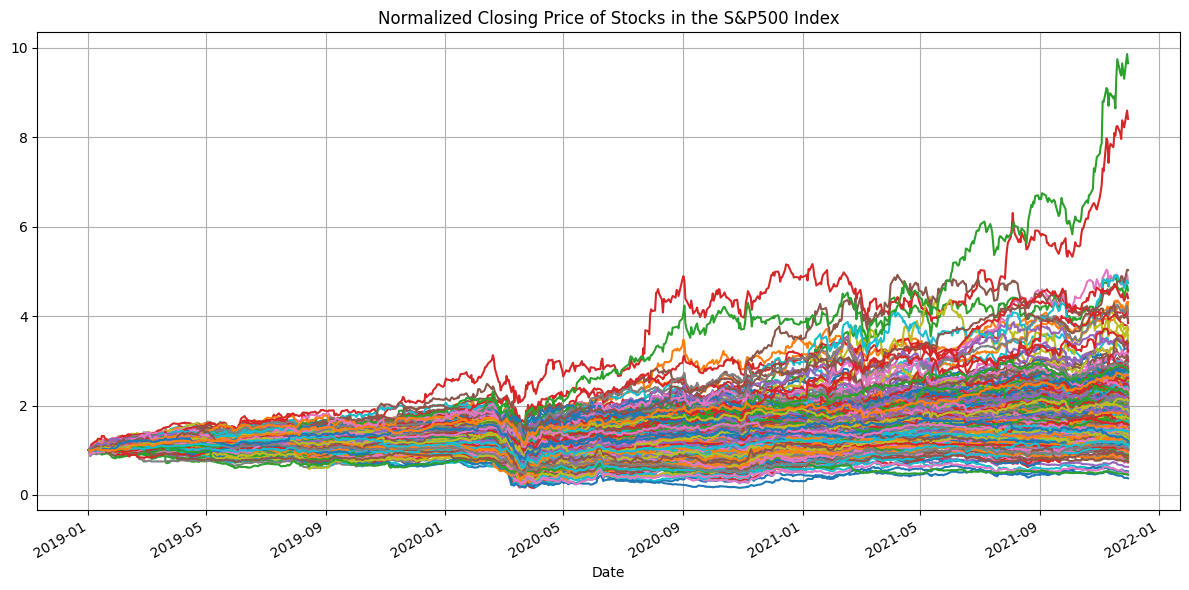

In [5]:
df=df/df.iloc[0]
df.plot(legend=0,figsize=(12,6), grid=True,title='Normalized Closing Price of Stocks in the S&P500 Index')
plt.tight_layout()

# Calculate Daily Log Returns

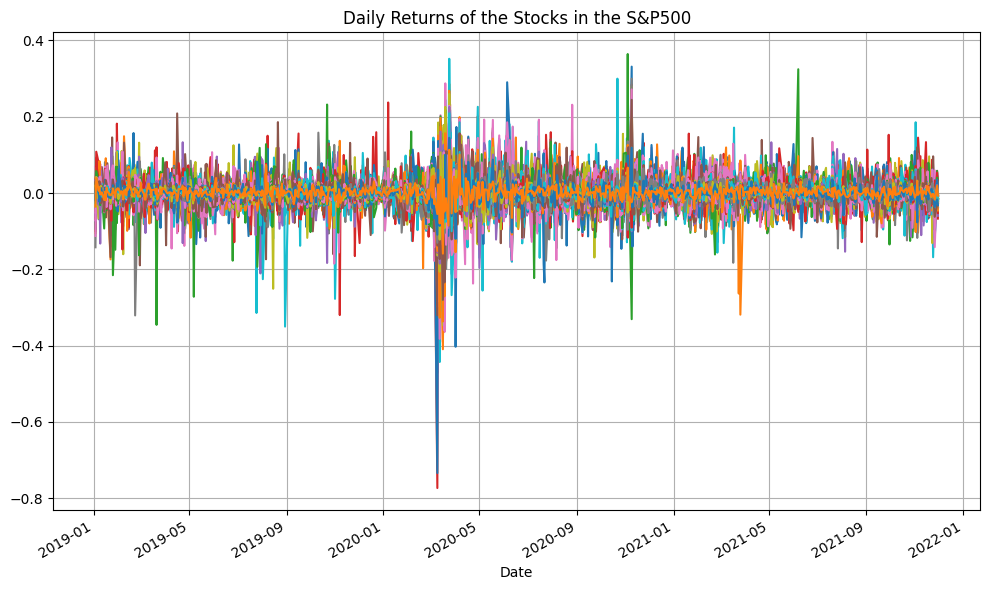

In [32]:
rs = df.apply(np.log).diff(1)
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()

# Principal Component Analysis
## PCA on Stock Returns

In [33]:
#standardize returns; mean=0, variance=1
rs_norm=( rs - rs.mean())/rs.std()

#perform pca on standarized returns
pca = PCA().fit(rs_norm.fillna(0))

Explained variance ratio of each component

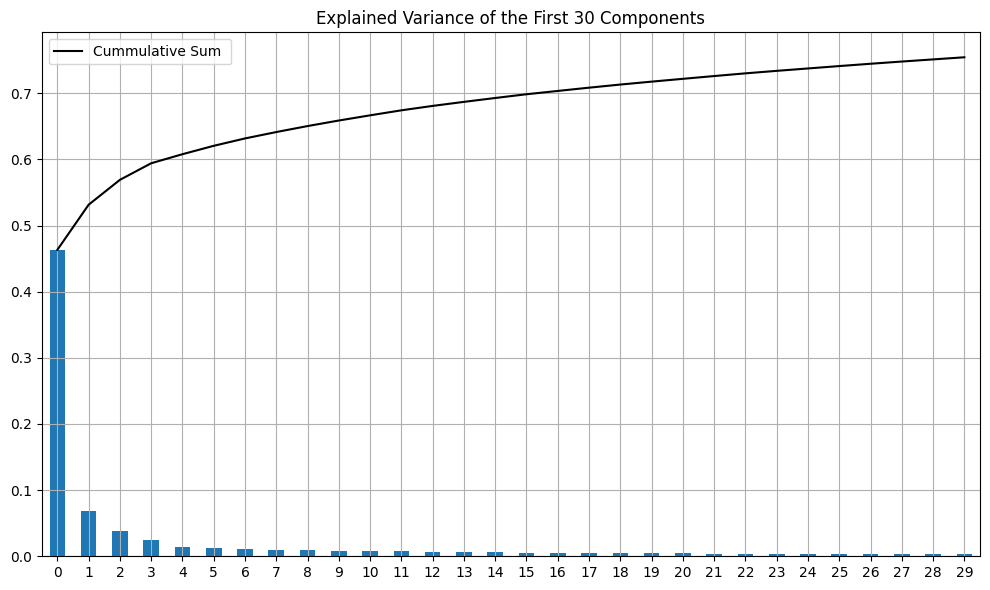

In [34]:
number_of_components=30
pd.Series(data=pca.explained_variance_ratio_[0:number_of_components]).plot.bar(figsize=(10,6), grid=True, title='Explained Variance of the First {i} Components'.format(i=number_of_components))
pd.Series(data=[np.sum(pca.explained_variance_ratio_[0:i]) for i in range(1,number_of_components+1)]).plot(figsize=(10,6), grid=True, label='Cummulative Sum ',color='black')
plt.legend()
plt.tight_layout()

## Weights of First PC

Number of stocks with a negative loading = 0


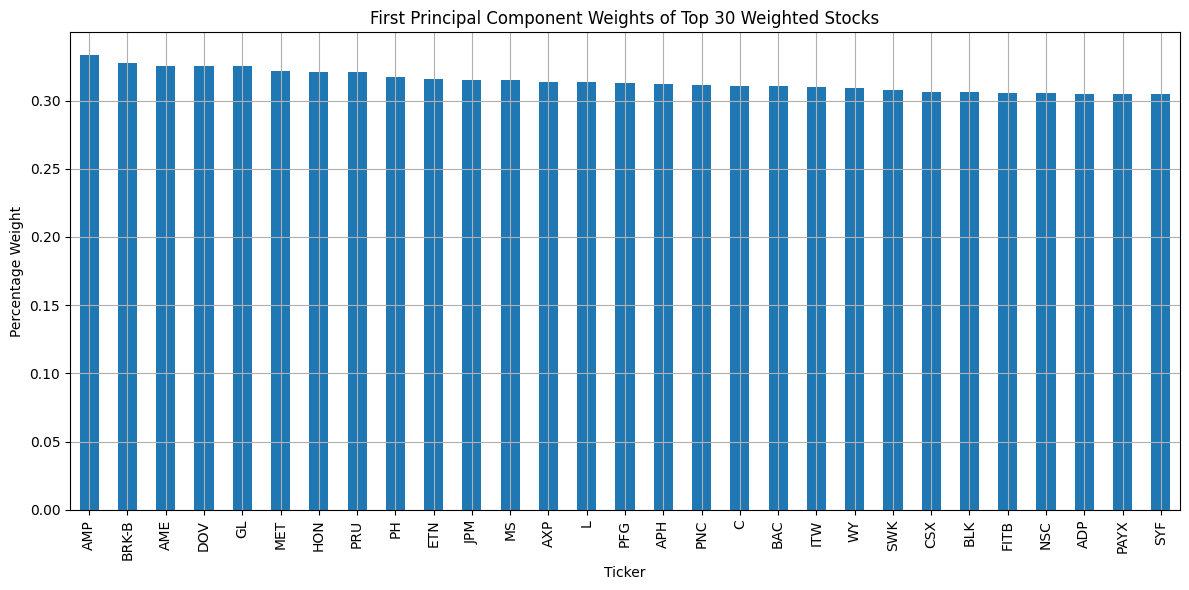

In [35]:
component_number=0
stock_weights_pca = (pca.components_[component_number])/(pca.components_[component_number]).sum()

all_same_direction = (np.array([np.sign(stock_weights_pca)== np.sign(stock_weights_pca[0])]))
print('Number of stocks with a negative loading =' , np.count_nonzero(all_same_direction[0]==False))

# define number of stocks to include
top_n = 30

bool_top_stocks = np.abs(stock_weights_pca) > np.sort(abs(stock_weights_pca))[len(stock_weights_pca)-top_n]

top_pca_weights = stock_weights_pca[bool_top_stocks]
top_pca_tickers = df.columns[bool_top_stocks]

top_pca_weighted_portfolio= pd.Series(index=top_pca_tickers,data=top_pca_weights)
top_pca_weighted_portfolio=top_pca_weighted_portfolio.iloc[np.flip(np.argsort(top_pca_weighted_portfolio.values))]
(100*top_pca_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='First Principal Component Weights of Top {i} Weighted Stocks'.format(i=top_n))
plt.tight_layout()

Compare PCA weighted protfolio with the market cap wieghted S&P500 index.

In [36]:
snp500 = yf.download('^GSPC', start='2019-01-01', end='2021-12-01')['Close']
rs_snp500 = snp500.apply(np.log).diff(1)

/tmp/ipython-input-36-1134139229.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  snp500 = yf.download('^GSPC', start='2019-01-01', end='2021-12-01')['Close']
[*********************100%***********************]  1 of 1 completed


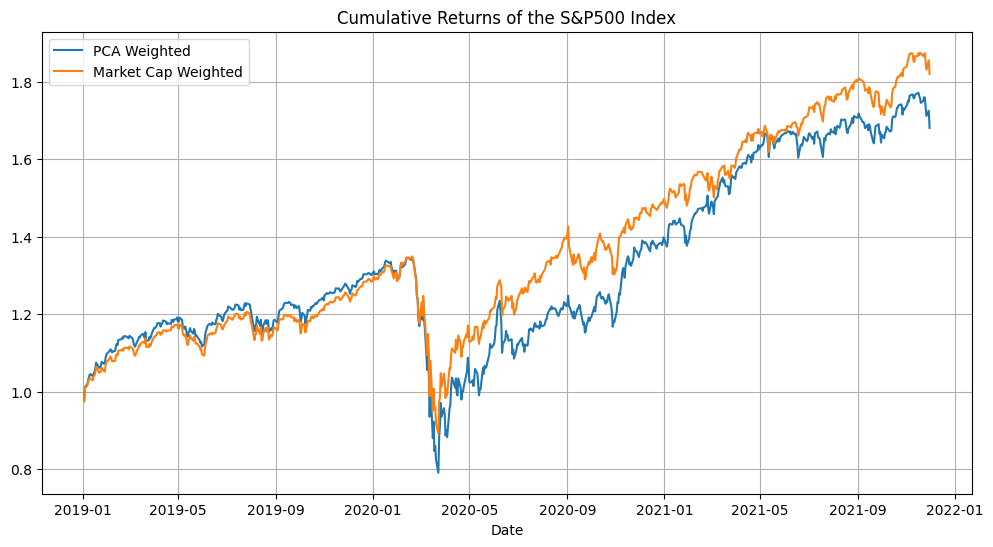

In [37]:
pca_weighted_portfolio_returns =rs.dot(np.abs(stock_weights_pca))

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pca_weighted_portfolio_returns).cumsum().apply(np.exp), label='PCA Weighted')
plt.plot((rs_snp500).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

## Restrict Date Range From March 2020 - December 2021

In [38]:
rs_covid=rs.loc['2020-03-01':'2021-12-31']
rs_snp500_covid = rs_snp500.loc['2020-03-01':'2021-12-31']

rs_covid_norm=rs_norm.loc['2020-03-01':'2021-12-31']

In [39]:
pca_covid = PCA().fit(rs_covid_norm.fillna(0))

## First PC During COVID

Number of stocks with a negative loading = 0


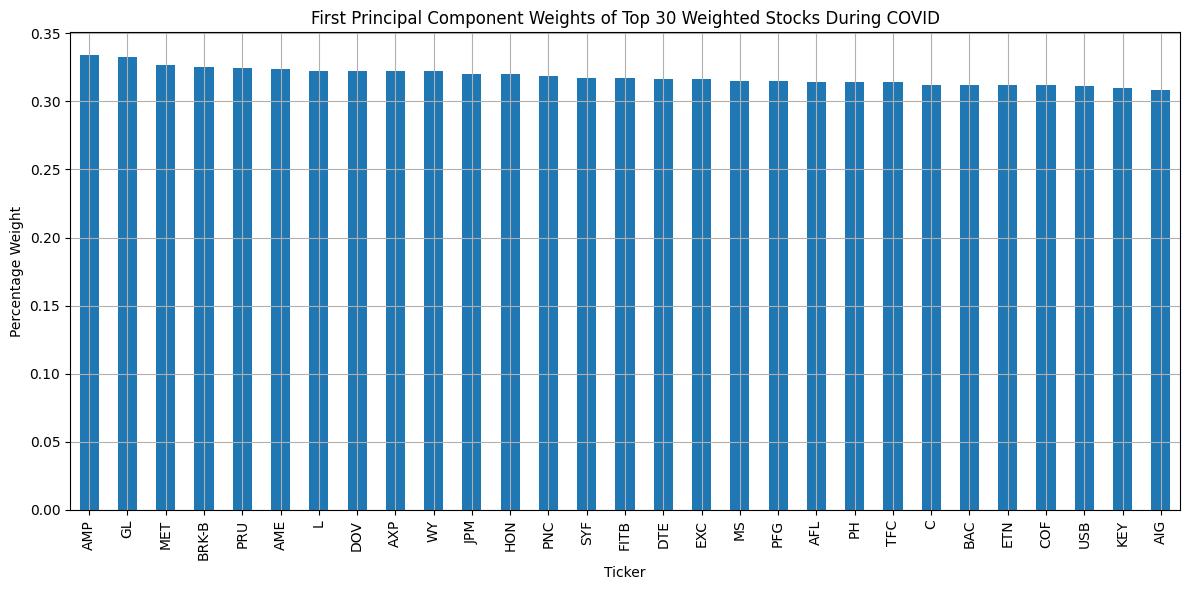

In [40]:
#Weight Stocks according to first principal component; normalize to sum up to 1
component_number=0
stock_weights_pca = (pca_covid.components_[component_number])/(pca_covid.components_[component_number]).sum()


all_same_direction = (np.array([np.sign(stock_weights_pca)== np.sign(stock_weights_pca[0])]))
print('Number of stocks with a negative loading =' , np.count_nonzero(all_same_direction[0]==False))

# define number of stocks to include
top_n = 30

bool_top_stocks = np.abs(stock_weights_pca) > np.sort(abs(stock_weights_pca))[len(stock_weights_pca)-top_n]

top_pca_weights = stock_weights_pca[bool_top_stocks]
top_pca_tickers = df.columns[bool_top_stocks]

top_pca_weighted_portfolio= pd.Series(index=top_pca_tickers,data=top_pca_weights)
top_pca_weighted_portfolio=top_pca_weighted_portfolio.iloc[np.flip(np.argsort(top_pca_weighted_portfolio.values))]
(100*top_pca_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='First Principal Component Weights of Top {i} Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

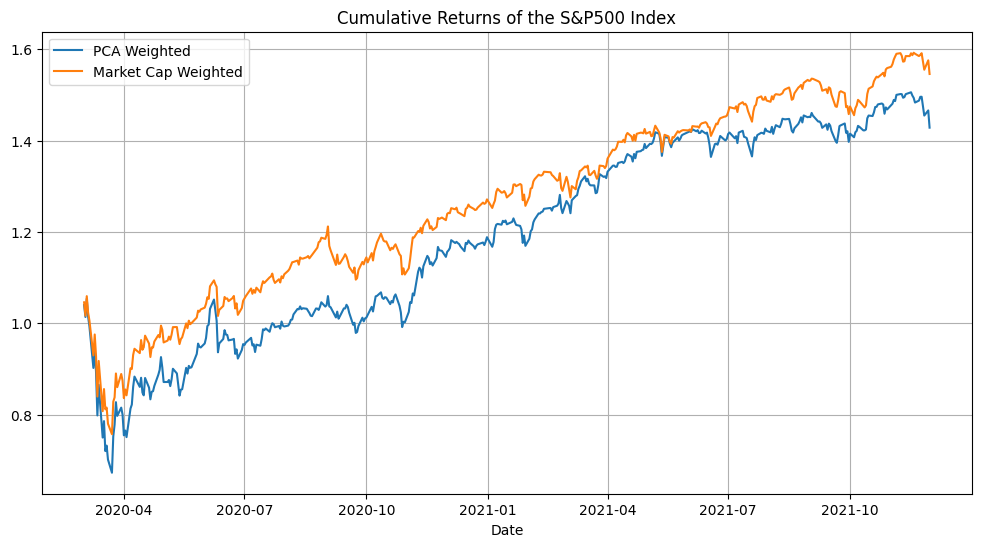

In [41]:
pca_weighted_portfolio_returns_covid =rs_covid.dot((stock_weights_pca))

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pca_weighted_portfolio_returns_covid).cumsum().apply(np.exp), label='PCA Weighted')
plt.plot((rs_snp500_covid).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

## Second PC During COVID
Again, the first PC represtents the market factor. To see which stocks moved against each other we take a look at the second PC.

In [42]:
print('The first PC explains = ', 100*pca_covid.explained_variance_ratio_[0], '% of the variance')
print('The second PC explains = ', 100*pca_covid.explained_variance_ratio_[1], '% of the variance')
print('The rest of the PC explain = ', 100*np.sum(pca_covid.explained_variance_ratio_[2:]), '% of the variance')

pc_number=1

all_pos = (np.array([pca_covid.components_[pc_number]>0]))
print('Number of stocks with an positive loading =' , np.sum(all_pos[0]))

all_neg = (np.array([pca_covid.components_[pc_number]<0]))
print('Number of stocks with an negative loading =' , np.sum(all_neg[0]))

The first PC explains =  51.00234764198508 % of the variance
The second PC explains =  7.667027238491412 % of the variance
The rest of the PC explain =  41.3306251195235 % of the variance
Number of stocks with an positive loading = 224
Number of stocks with an negative loading = 178


Make two portfolios; consisting of the stocks with negative weights and those with positive weights.

Note; actual sign does not matter.

In [43]:
pos_weights = pca_covid.components_[pc_number][all_pos[0]]
neg_weights = pca_covid.components_[pc_number][all_neg[0]]

#normalize
pos_weights =pos_weights/np.sum(pos_weights)
neg_weights =abs(neg_weights)/np.sum(abs(neg_weights))

In sample (COVID period) cumulative returns

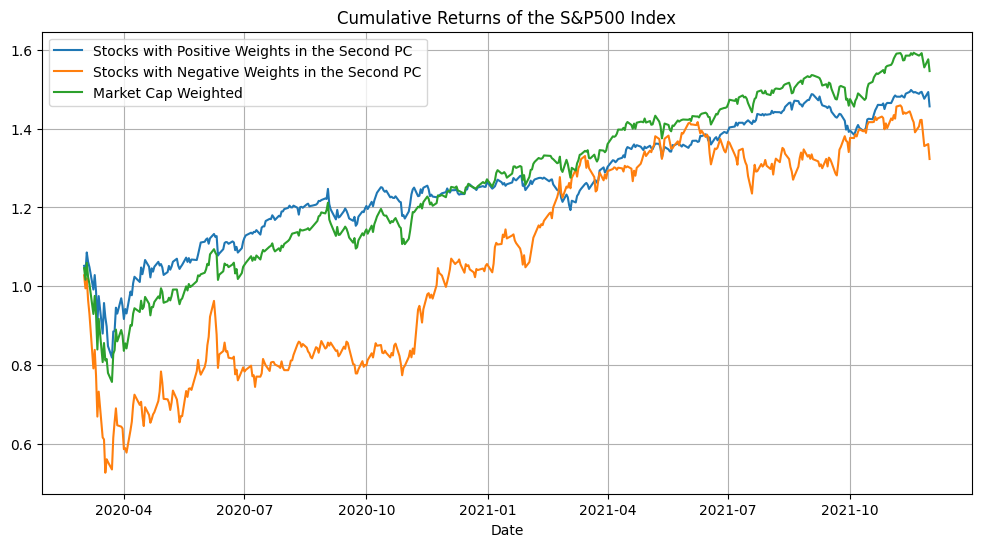

In [44]:
pos_pca_portfolio_rs_covid = rs_covid.loc[:,all_pos[0]].dot(pos_weights)
neg_pca_portfolio_rs_covid = rs_covid.loc[:,all_neg[0]].dot(neg_weights)

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pos_pca_portfolio_rs_covid).cumsum().apply(np.exp), label='Stocks with Positive Weights in the Second PC')
plt.plot((neg_pca_portfolio_rs_covid).cumsum().apply(np.exp), label='Stocks with Negative Weights in the Second PC')
plt.plot((rs_snp500_covid).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

Returns over whole time period including Pre-COVID

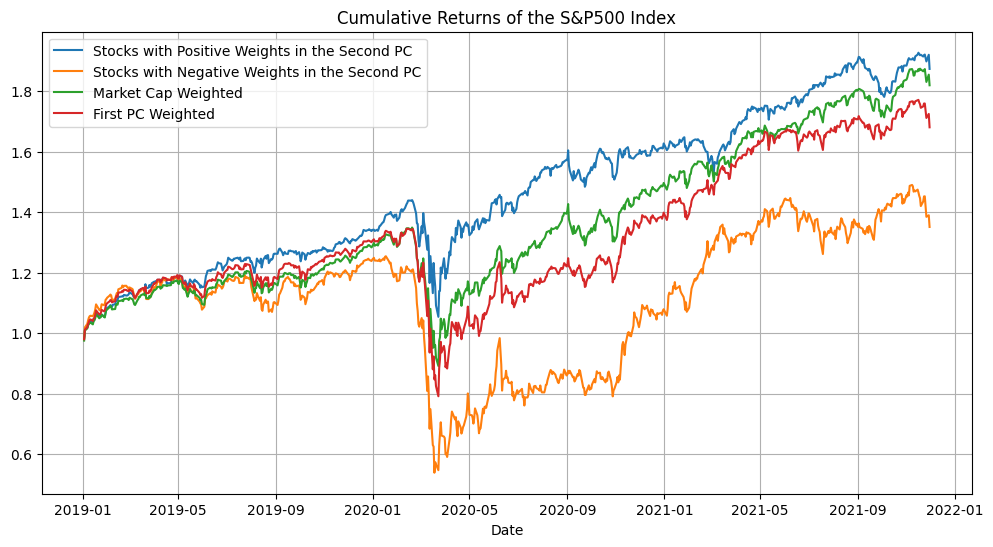

In [45]:
pos_pca_portfolio_rs = rs.loc[:,all_pos[0]].dot(pos_weights)
neg_pca_portfolio_rs = rs.loc[:,all_neg[0]].dot(neg_weights)

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pos_pca_portfolio_rs).cumsum().apply(np.exp), label='Stocks with Positive Weights in the Second PC')
plt.plot((neg_pca_portfolio_rs).cumsum().apply(np.exp), label='Stocks with Negative Weights in the Second PC')
plt.plot((rs_snp500).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.plot((pca_weighted_portfolio_returns).cumsum().apply(np.exp), label='First PC Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

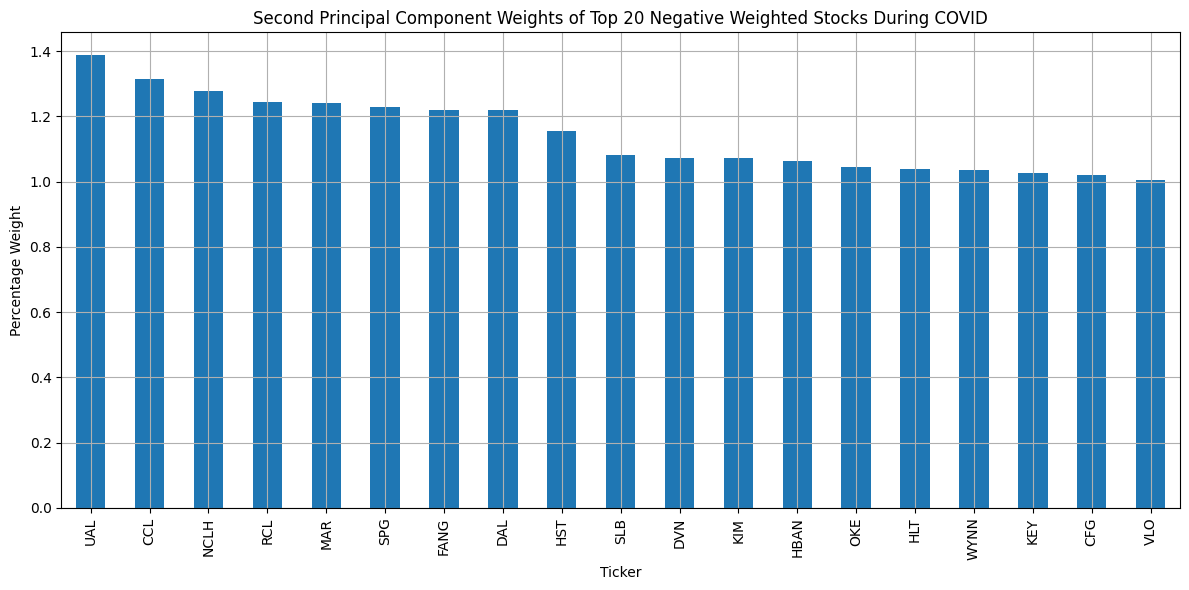

In [46]:
top_n = 20

bool_top_stocks = np.abs(neg_weights) > np.sort(abs(neg_weights))[len(neg_weights)-top_n]
top_neg_weights = neg_weights[bool_top_stocks]
top_neg_tickers = df.columns[all_neg[0]][bool_top_stocks]

top_neg_weighted_portfolio= pd.Series(index=top_neg_tickers,data=top_neg_weights)
top_neg_weighted_portfolio=top_neg_weighted_portfolio.iloc[np.flip(np.argsort(top_neg_weighted_portfolio.values))]
(100*top_neg_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='Second Principal Component Weights of Top {i} Negative Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

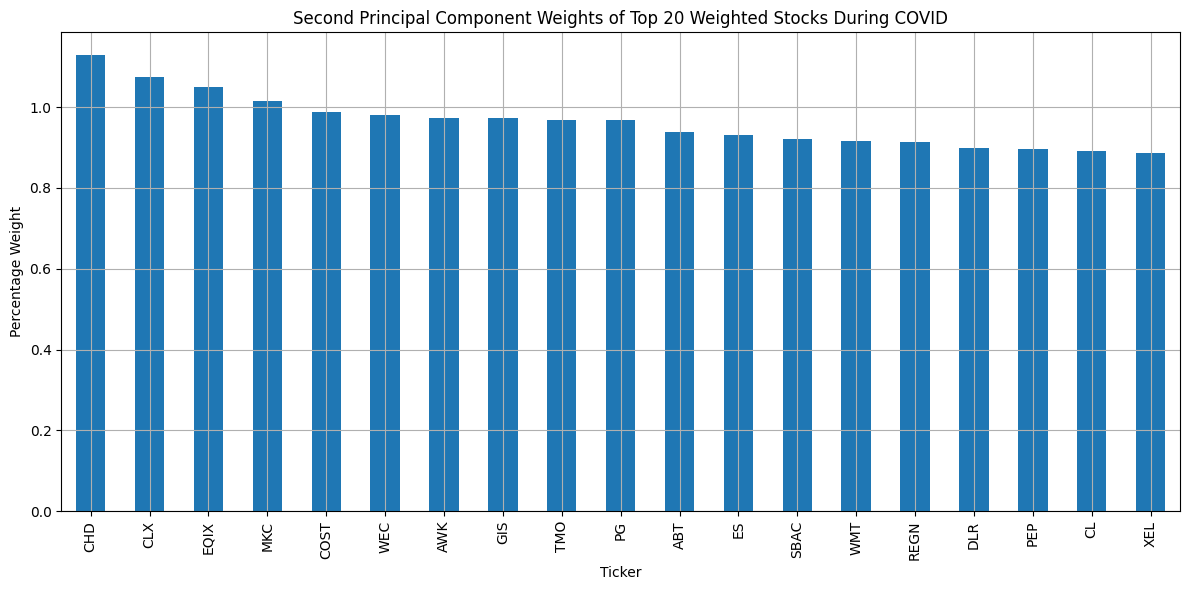

In [47]:
top_n = 20

bool_top_stocks = np.abs(pos_weights) > np.sort(abs(pos_weights))[len(pos_weights)-top_n]
top_pos_weights = pos_weights[bool_top_stocks]
top_pos_tickers = df.columns[all_pos[0]][bool_top_stocks]

top_pos_weighted_portfolio= pd.Series(index=top_pos_tickers,data=top_pos_weights)
top_pos_weighted_portfolio=top_pos_weighted_portfolio.iloc[np.flip(np.argsort(top_pos_weighted_portfolio.values))]
(100*top_pos_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='Second Principal Component Weights of Top {i} Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

In [48]:
top_n =20

top_neg_sectors = np.array([yf.Ticker(ticker).info.get('sector') for ticker in top_neg_weighted_portfolio.index[:top_n+1] ] )
print('Sectors of the most heavily wieghted stocks with a negative loading in the second PC' , np.unique(top_neg_sectors))

top_pos_sectors = np.array([yf.Ticker(ticker).info.get('sector') for ticker in top_pos_weighted_portfolio.index[:top_n+1] ] )
print('Sectors of the most heavily wieghted stocks with a positive loading in the second PC' , np.unique(top_pos_sectors))

Sectors of the most heavily wieghted stocks with a negative loading in the second PC ['Consumer Cyclical' 'Energy' 'Financial Services' 'Industrials'
 'Real Estate']
Sectors of the most heavily wieghted stocks with a positive loading in the second PC ['Consumer Defensive' 'Healthcare' 'Real Estate' 'Utilities']


Get Portfolio Statistics

In [49]:
mean_pos=(pos_pca_portfolio_rs.mean()*252*100)
mean_neg=(neg_pca_portfolio_rs.mean()*252*100)
mean_snp500=(rs_snp500.mean().values*252*100)
print(mean_pos,mean_neg,mean_snp500)

std_pos=(pos_pca_portfolio_rs.std()*np.sqrt(252)*100)
std_neg=(neg_pca_portfolio_rs.std()*np.sqrt(252)*100)
std_snp500 = (rs_snp500.std().values*np.sqrt(252)*100)
print(std_pos,std_neg,std_snp500)

sharpe_pos=mean_pos/std_pos
sharpe_neg=mean_neg/std_neg
sharpe_snp500=mean_snp500/std_snp500
print(sharpe_pos,sharpe_neg,sharpe_snp500)


pos_series = (pos_pca_portfolio_rs).cumsum().apply(np.exp)
drawdown_pos= (100*(pos_series.cummax()-pos_series)/pos_series.cummax()).max()

neg_series = (neg_pca_portfolio_rs).cumsum().apply(np.exp)
drawdown_neg= (100*(neg_series.cummax()-neg_series)/neg_series.cummax()).max()

snp500_series = (rs_snp500).cumsum().apply(np.exp).dropna()

drawdown_snp500 = (100*(snp500_series.cummax().values-snp500_series.values)/snp500_series.cummax().values).max()

print(drawdown_pos,drawdown_neg,drawdown_snp500)

21.555819862067295 10.327417577920848 [20.55007874]
19.908571119557415 37.157469729252206 [22.7503562]
1.082740681519413 0.2779365132548461 [0.90328602]
26.810529922854947 57.07784508637461 33.92496000265325


## Third PC

In [50]:
print('The first PC explains = ', 100*pca_covid.explained_variance_ratio_[0], '% of the variance')
print('The second PC explains = ', 100*pca_covid.explained_variance_ratio_[1], '% of the variance')

pc_number=2

all_pos = (np.array([pca_covid.components_[pc_number]>0]))
print('Number of stocks with an positive loading =' , np.sum(all_pos[0]))

all_neg = (np.array([pca_covid.components_[pc_number]<0]))
print('Number of stocks with an negative loading =' , np.sum(all_neg[0]))

The first PC explains =  51.00234764198508 % of the variance
The second PC explains =  7.667027238491412 % of the variance
Number of stocks with an positive loading = 196
Number of stocks with an negative loading = 206


Make two portfolios; consisting of the stocks with negative weights and those with positive weights.

Note; actual sign does not matter.

In [51]:
pos_weights = pca_covid.components_[pc_number][all_pos[0]]/rs.loc[:,all_pos[0]].std()
neg_weights = pca_covid.components_[pc_number][all_neg[0]]/rs.loc[:,all_neg[0]].std()

#normalize
pos_weights =pos_weights/np.sum(pos_weights)
neg_weights =abs(neg_weights)/np.sum(abs(neg_weights))

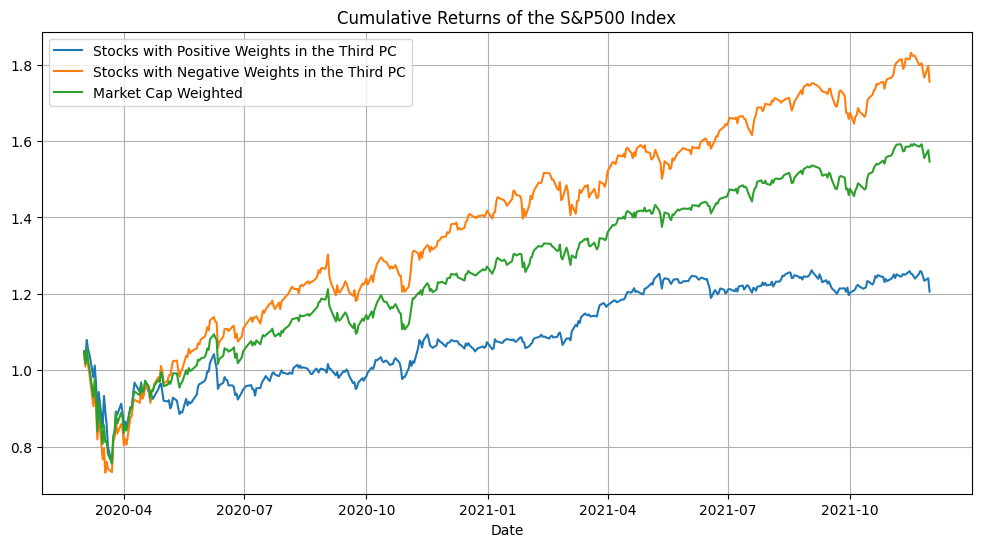

In [52]:
pos_pca_portfolio_rs_covid = rs_covid.loc[:,all_pos[0]].dot(pos_weights)
neg_pca_portfolio_rs_covid = rs_covid.loc[:,all_neg[0]].dot(neg_weights)

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pos_pca_portfolio_rs_covid).cumsum().apply(np.exp), label='Stocks with Positive Weights in the Third PC')
plt.plot((neg_pca_portfolio_rs_covid).cumsum().apply(np.exp), label='Stocks with Negative Weights in the Third PC')
plt.plot((rs_snp500_covid).cumsum().apply(np.exp), label='Market Cap Weighted')
#plt.plot((pca_weighted_portfolio_returns).cumsum().apply(np.exp), label='First PC Weighted')

plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

Compare over pre-COVID and COVID period

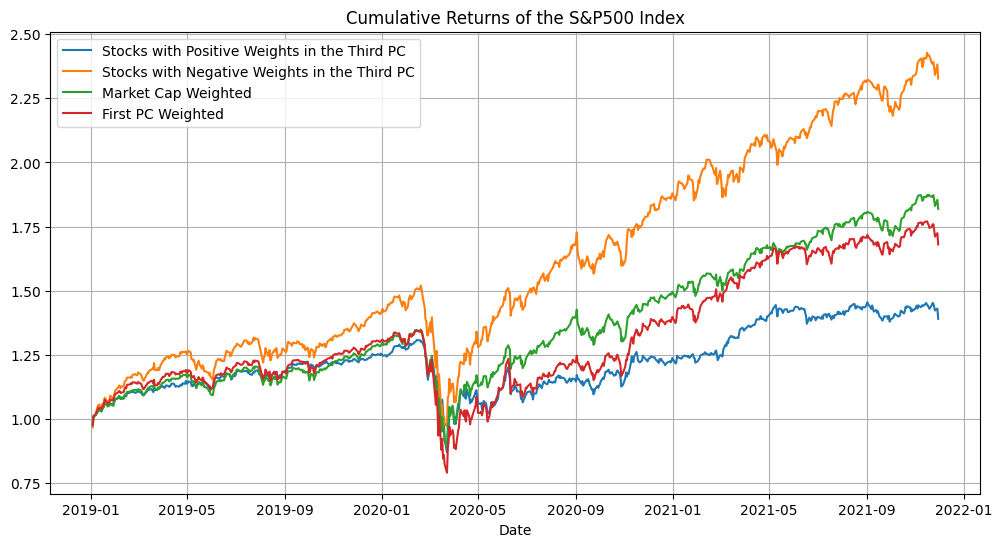

In [53]:
pos_pca_portfolio_rs = rs.loc[:,all_pos[0]].dot(pos_weights)
neg_pca_portfolio_rs = rs.loc[:,all_neg[0]].dot(neg_weights)

# Plot the cumulative returns of the PCA-based portfolio and the S&P 500
plt.figure(figsize=(12, 6))
plt.plot((pos_pca_portfolio_rs).cumsum().apply(np.exp), label='Stocks with Positive Weights in the Third PC')
plt.plot((neg_pca_portfolio_rs).cumsum().apply(np.exp), label='Stocks with Negative Weights in the Third PC')
plt.plot((rs_snp500).cumsum().apply(np.exp), label='Market Cap Weighted')
plt.plot((pca_weighted_portfolio_returns).cumsum().apply(np.exp), label='First PC Weighted')
plt.legend()
plt.grid(True)
plt.xlabel('Date')
plt.title('Cumulative Returns of the S&P500 Index')
plt.show()

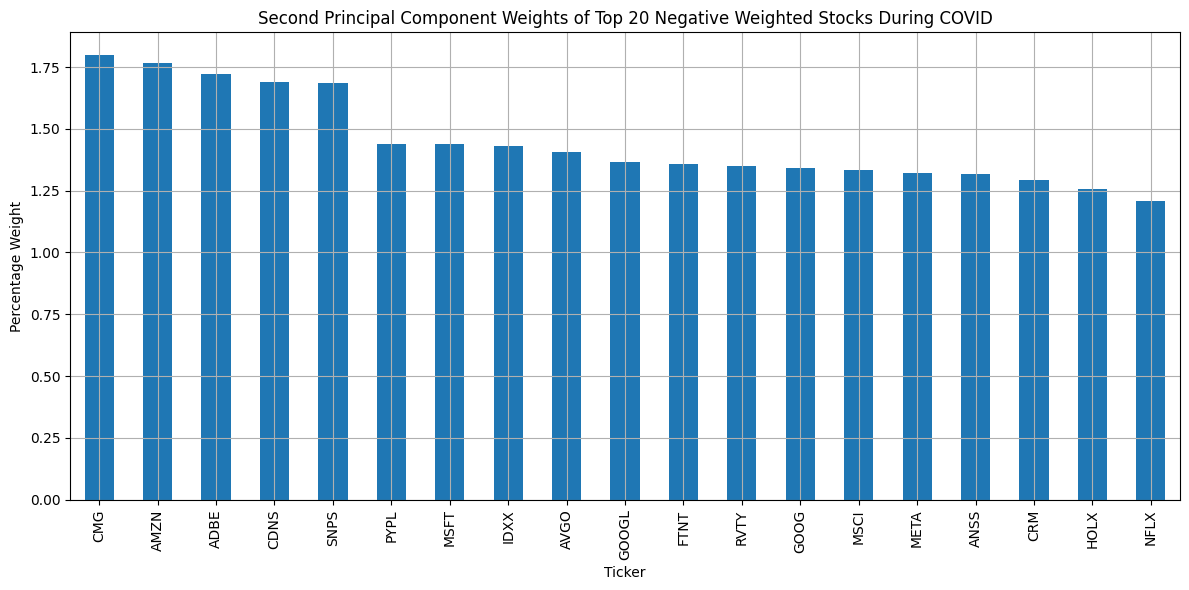

In [54]:
top_n = 20

bool_top_stocks = np.abs(neg_weights) > np.sort(abs(neg_weights))[len(neg_weights)-top_n]
top_neg_weights = neg_weights[bool_top_stocks]
top_neg_tickers = df.columns[all_neg[0]][bool_top_stocks]

top_neg_weighted_portfolio= pd.Series(index=top_neg_tickers,data=top_neg_weights)
top_neg_weighted_portfolio=top_neg_weighted_portfolio.iloc[np.flip(np.argsort(top_neg_weighted_portfolio.values))]
(100*top_neg_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='Second Principal Component Weights of Top {i} Negative Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

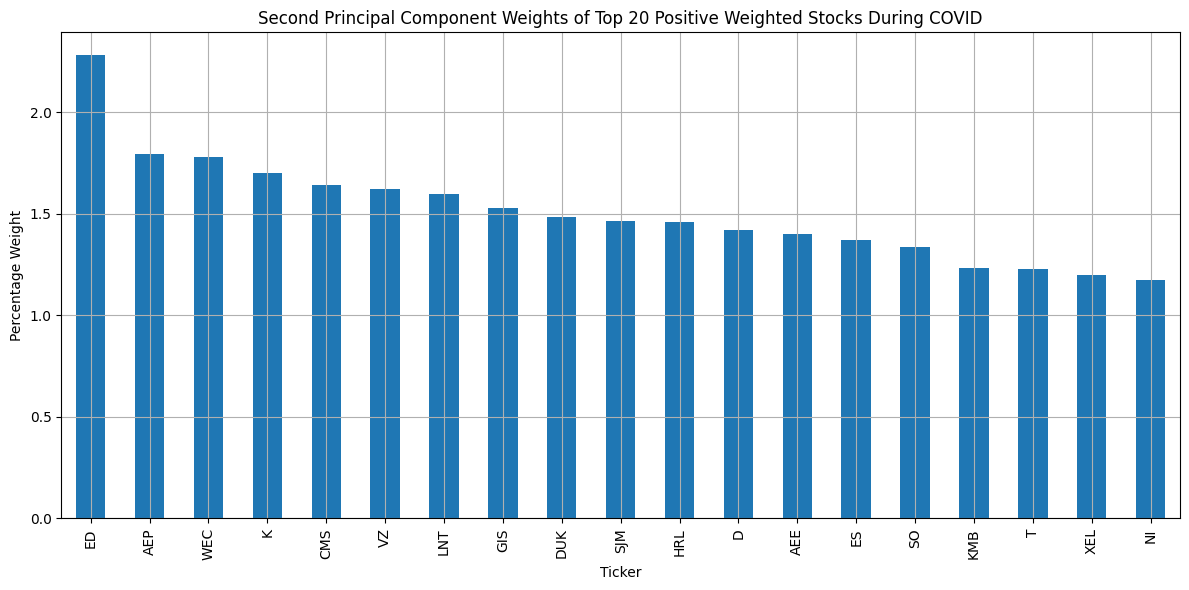

In [55]:
top_n = 20

bool_top_stocks = np.abs(pos_weights) > np.sort(abs(pos_weights))[len(pos_weights)-top_n]
top_pos_weights = pos_weights[bool_top_stocks]
top_pos_tickers = df.columns[all_pos[0]][bool_top_stocks]

top_pos_weighted_portfolio= pd.Series(index=top_pos_tickers,data=top_pos_weights)
top_pos_weighted_portfolio=top_pos_weighted_portfolio.iloc[np.flip(np.argsort(top_pos_weighted_portfolio.values))]
(100*top_pos_weighted_portfolio).plot.bar(legend=0, figsize=(12,6), grid=True,ylabel='Percentage Weight', title='Second Principal Component Weights of Top {i} Positive Weighted Stocks During COVID'.format(i=top_n))
plt.tight_layout()

Get sectors

In [56]:
top_n =10

top_neg_sectors = np.array([yf.Ticker(ticker).info.get('sector') for ticker in top_neg_weighted_portfolio.index[:top_n+1] ] )
print('Sectors of the most heavily wieghted stocks with a negative loading in the second PC' , np.unique(top_neg_sectors))

top_pos_sectors = np.array([yf.Ticker(ticker).info.get('sector') for ticker in top_pos_weighted_portfolio.index[:top_n+1] ] )
print('Sectors of the most heavily wieghted stocks with a positive loading in the second PC' , np.unique(top_pos_sectors))

Sectors of the most heavily wieghted stocks with a negative loading in the second PC ['Communication Services' 'Consumer Cyclical' 'Financial Services'
 'Healthcare' 'Technology']
Sectors of the most heavily wieghted stocks with a positive loading in the second PC ['Communication Services' 'Consumer Defensive' 'Utilities']


Get metrics

In [57]:
mean_pos=(pos_pca_portfolio_rs.mean()*252*100)
mean_neg=(neg_pca_portfolio_rs.mean()*252*100)
mean_snp500=(rs_snp500.mean().values*252*100)
print(mean_pos,mean_neg,mean_snp500)

std_pos=(pos_pca_portfolio_rs.std()*np.sqrt(252)*100)
std_neg=(neg_pca_portfolio_rs.std()*np.sqrt(252)*100)
std_snp500 = (rs_snp500.std().values*np.sqrt(252)*100)
print(std_pos,std_neg,std_snp500)

sharpe_pos=mean_pos/std_pos
sharpe_neg=mean_neg/std_neg
sharpe_snp500=mean_snp500/std_snp500
print(sharpe_pos,sharpe_neg,sharpe_snp500)


pos_series = (pos_pca_portfolio_rs).cumsum().apply(np.exp)
drawdown_pos= (100*(pos_series.cummax()-pos_series)/pos_series.cummax()).max()

neg_series = (neg_pca_portfolio_rs).cumsum().apply(np.exp)
drawdown_neg= (100*(neg_series.cummax()-neg_series)/neg_series.cummax()).max()

snp500_series = (rs_snp500).cumsum().apply(np.exp).dropna()

drawdown_snp500 = (100*(snp500_series.cummax().values-snp500_series.values)/snp500_series.cummax().values).max()

print(drawdown_pos,drawdown_neg,drawdown_snp500)

11.328522251877445 28.99803386274822 [20.55007874]
21.611014259926797 25.448658660185718 [22.7503562]
0.5242013223268225 1.1394719953596406 [0.90328602]
33.472863078387185 36.173650741085005 33.92496000265325
